## Limit Flux To Core example notebook

Tyler W. H. Backman

Required inputs:
* input model
* exchange fluxes including biomass, and carbon feed uptake
* list of reactions which are considered 'core' reactions

Output produced:
* an updated version of the input model, where flux bounds are set to minimize fluxes into core, compatible with the exchange fluxes

First we will install the lftc package, in a manner that works if ran within the debian-cheminformatics Jupyter notebook server, as launched with the following command:

docker run -it --rm -v `pwd`:/f -w /f -p 8888:8888 tbackman/debian-cheminformatics jupyter notebook --no-browser --ip=* --allow-root

In [1]:
import os
os.system('pip3 install -e ../')

0

In [2]:
import lftc
import cobra
import re
import tempfile
import math
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:1,.5f}'.format # don't use scientific notation in output

Import SBML model

In [3]:
model = cobra.io.read_sbml_model('test_data/EciJR904TKs_sbml3.xml')

Set exchange fluxes to experimental values from Toya2010 wt5h 

In [4]:
model.reactions.EX_glc_e_.lower_bound = -11.7
model.reactions.EX_glc_e_.upper_bound = -11.7
model.reactions.EX_ac_e_.lower_bound = 4.3
model.reactions.EX_ac_e_.upper_bound = 4.3
model.reactions.BiomassEcoli.lower_bound = 0.83
model.reactions.BiomassEcoli.upper_bound = 0.89

Read in the jQMM formatted atom transitions to get the reaction core

In [5]:
with open('test_data/REACTIONSwt5h.txt') as f:
    allLines = f.readlines()
reactionLines = list(filter(lambda l: re.match('^\w', l), allLines))
coreReactionNamesFromFile = set([re.sub('\s.*$', '', l) for l in reactionLines])
coreReactionNamesFromFile = set([re.sub('[\(,\)]', '_', l) for l in coreReactionNamesFromFile])
coreReactionNames = coreReactionNamesFromFile.intersection([r.id for r in model.reactions])

print(str(len(coreReactionNamesFromFile)) + ' core reactions in transitions file')
print(str(len(coreReactionNames)) + ' overlapping with model')
print('missing from model: ', coreReactionNamesFromFile.difference(coreReactionNames))

127 core reactions in transitions file
127 overlapping with model
missing from model:  set()


Run Limit Flux To Core to determine the sum of fluxes into core required to satisfy the exchanges

In [6]:
fluxIntoCore, producingFluxes, consumingFluxes = lftc.limitFluxToCore(coreReactionNames, model)
fluxIntoCore

3.1875701799999807

Show all fluxes into the core where the upper bound could not be set to zero

In [7]:
# optionally write these fluxes to a csv file
# producingFluxesNonZero = producingFluxes[producingFluxes > 0]
# producingFluxesNonZero.to_csv('test_data/new_fluxes.csv')

producingFluxes[producingFluxes > 0]

AICART    0.47136
CYSS      0.19344
CTPS2     0.12566
GARFT     0.34933
ADCL      0.04150
UHGADA    0.01394
DKMPPD    0.00581
METS      0.12118
SDPDS     0.29349
OMCDC     0.35524
GTPCI     0.04150
SHSL1     0.12118
DB4PS     0.00002
GF6PTA    0.05976
UNK3      0.00581
IMPD      0.23108
CYSTL     0.12118
ADCS      0.04150
IG3PS     0.07470
DHFR      0.06200
ANS       0.04482
GTPCII2   0.00001
HSTPT     0.07470
TRPS1     0.04482
THDPS     0.29349
MOHMT     0.00005
Name: fluxes, dtype: float64

Show all reversible fluxes out of core where the lower bound could not be set to zero

In [8]:
consumingFluxes[consumingFluxes < 0]

Series([], Name: fluxes, dtype: float64)

Write model with new bounds to a new file

In [9]:
updatedModel = lftc.setModelFluxes(model, producingFluxes, consumingFluxes)
cobra.io.write_sbml_model(updatedModel, 'test_data/EciJR904TKs_sbml3_fluxbounds.xml', use_fbc_package=True)

# also write old sbml2 format
# cobra.io.sbml.write_cobra_model_to_sbml_file(updatedModel, 'test_data/EciJR904TKs_sbml2_fluxbounds.xml', sbml_level=2, sbml_version=1,use_fbc_package=False)

Setup simulated annealing problem to identify an improved core, while keeping 100% of the initial core

Note: the logFile option is not required, and substantially slows down the simulation. If used, you must also remember to run ocp.logFile.close() to close the logfile before reading it.

In [10]:
exchanges = {r.id for r in model.exchanges}
logFile = tempfile.mktemp()
ocp = lftc.OptimalCoreProblem(
    state=coreReactionNames,
    model=model, 
    feed='EX_glc_e_',
    minOverlapWithStart=1.0,
    maxOverlapWithModel=0.13,
    logFile=logFile,
    excludeReactions=exchanges,
    )
ocp.energy()

3.1875701799999807

Run simulated annealing problem to find an improved core, and print out it's size and score

In [11]:
schedule = {'steps': 20000, 'tmax': 50000, 'tmin': 0.01, 'updates': 1000}
ocp.set_schedule(schedule)
coreReactions, score = ocp.anneal(seed=42)
ocp.logFile.close()
print(len(coreReactions))
print(score)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.01000          1.61    55.00%     5.00%     0:27:42     0:00:00

141
1.57504784


Note that you can optionally run ocp.prune() after the simulation to remove any extra reactions that don't improve the core reaction set. Here the core size reduces from 141 to 136 while keeping the same energy (sum of fluxes into core metabolism), showing that those extra reactions were unnecessary.

In [20]:
ocp.prune()
print('Reactions after pruning:', len(ocp.state))
print('Energy after pruning:', ocp.energy())

Reactions after pruning: 136
Energy after pruning: 1.57504784


Plot the simulated annealing trace

In [12]:
# read in and delete logfile
df = pd.read_csv(logFile)
os.unlink(logFile)

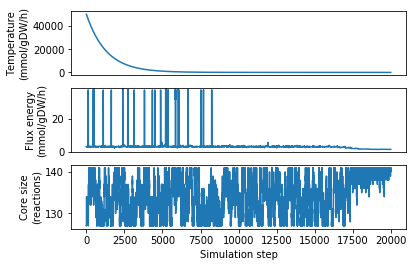

In [21]:
# set temp schedule to match generated results
Tfactor = -math.log(schedule['tmax'] / schedule['tmin'])
annealingSchedule = [schedule['tmax'] * math.exp(Tfactor * step / df.shape[0]) for step in range(0,df.shape[0])]

# plot the data
%matplotlib inline
plt.figure(1)
plt.subplot(311)
plt.plot(annealingSchedule)
plt.ylabel('Temperature\n(mmol/gDW/h)')
plt.subplot(311).axes.get_xaxis().set_visible(False)
plt.subplot(312)
plt.plot(df['energy'])
plt.ylabel('Flux energy\n(mmol/gDW/h)')
plt.ylim([0,max(df['energy'])])
plt.subplot(312).axes.get_xaxis().set_visible(False)
plt.subplot(313)
plt.plot(df['size'])
# plt.ylim([0,max(df['size'])])
plt.ylabel('Core size\n(reactions)')
plt.xlabel('Simulation step')